In [1]:
import tensorflow as tf
import numpy as np
import glob
import os
import re
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
def plotPoke(x, n_row=10):
    f, a = plt.subplots(2, n_row, figsize=(n_row, 2))
    for i in range(n_row):
        a[0][i].imshow(x[i])
        a[0,i].axis('off')
        a[1][i].imshow(x[i+n_row])
        a[1,i].axis('off')
    f.show()
    plt.draw()

Input data shape: (792, 40, 40, 3)


/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


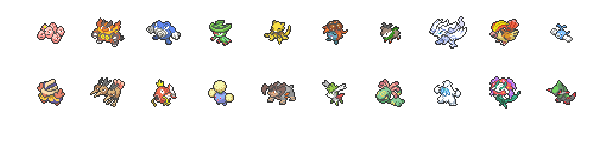

In [3]:
# Create an empty array to store pokemon pics
orig_img = np.empty((0, 40, 40, 3), dtype='float32')
# Load all images and append into orig_img
path = os.path.abspath("./AE_RGB.ipynb")
path = re.sub('[a-zA-Z\s._]+$', '', path)
for pic in glob.glob(path+'Pokemon/*.png'):
    img = mpimg.imread(pic)
    # remove alpha channel  %some alpha=0 but RGB is not equal to [1., 1., 1.]
    img[img[:,:,3]==0] = np.ones((1,4))
    img = img[:,:,0:3]
    orig_img = np.append(orig_img, [img], axis=0)

# Use plt to show original images 
print 'Input data shape: {}'.format(orig_img.shape)
plotPoke(orig_img)

In [192]:
# Parameters
learning_rate = 0.001
training_epochs = 100
batch_size = 24
display_step = 5
examples_to_show = 10
l2_lambda = 0.01 # regularization weight

# Network Parameters
n_input = [40, 40, 3] # Pokemon data input (img shape: 40*40*3)
n_channel1 = 16
n_latent = 32

# tf Graph input
X = tf.placeholder(tf.float32, [None]+n_input)

In [201]:
# Store layers weights & biases
weights = {
    # 5x5 conv, 3 inputs, 16 outputs
    'encoder_h1': tf.Variable(tf.truncated_normal([5, 5, 3, n_channel1], stddev=0.01)),
    
    # 5x5 conv, 16 inputs, 32 outputs
    'latent_mu' : tf.Variable(tf.truncated_normal([5, 5, n_channel1, n_latent], stddev=0.01)),
    'latent_sig': tf.Variable(tf.truncated_normal([5, 5, n_channel1, n_latent], stddev=0.01)),
    
    # 5x5 conv, 32 inputs, 16 outputs
    'decoder_h1': tf.Variable(tf.truncated_normal([5, 5, n_channel1, n_latent], stddev=0.01)),
    # 5x5 conv, 16 inputs, 3 outputs
    'decoder_h2': tf.Variable(tf.truncated_normal([5, 5, 3, n_channel1], stddev=0.01))
}

biases = {
    'encoder_h1': tf.Variable(tf.truncated_normal([n_channel1], stddev=0.01)),
    'latent_mu' : tf.Variable(tf.truncated_normal([n_latent], stddev=0.01)),
    'latent_sig': tf.Variable(tf.truncated_normal([n_latent], stddev=0.01)),
    'decoder_h1': tf.Variable(tf.truncated_normal([n_channel1], stddev=0.01)),
    'decoder_h2': tf.Variable(tf.truncated_normal([3], stddev=0.01)),
}

In [202]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    return tf.nn.bias_add(x, b)

def deconv2d(x, W, b, out_shape, strides=1):
    x = tf.nn.conv2d_transpose(x, W, out_shape, strides=[1, strides, strides, 1], 
                               padding='SAME')
    return tf.nn.bias_add(x, b)
    
def maxPool(x, size=2, stride=2):
    _, argmax = tf.nn.max_pool_with_argmax(x, ksize=[1,size,size,1], strides=[1,stride,stride,1], padding = 'SAME')
    pool = tf.nn.max_pool(x, ksize = [1, size, size, 1], strides = [1, stride, stride, 1], padding = 'SAME')
    return pool, argmax

def unMaxPool(x, shape, size=2):
    inference = tf.image.resize_nearest_neighbor(x, size=tf.stack([shape[1]*size, shape[2]*size]))
    return inference

# Define leaky rectified linear unit (ReLu)
def lrelu(x, leak=0.2, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

In [213]:
# Create model
def conv_vae(x, weights=weights, biases=biases):
    # Convolution Layer and Max Pool Layer
    conv1 = conv2d(x, weights['encoder_h1'], biases['encoder_h1'])
    conv1 = tf.nn.tanh(conv1)
    maxpool1, _ = maxPool(conv1)

    # Latent Layer
    mu = conv2d(maxpool1, weights['latent_mu'], biases['latent_mu'])
    layer_mu = tf.nn.tanh(mu)
    sig = conv2d(maxpool1, weights['latent_sig'], biases['latent_sig'])
    layer_sig = tf.nn.tanh(sig)
    KLD = -0.5 * tf.reduce_sum(1+sig-tf.pow(mu, 2)-tf.exp(sig), reduction_indices=(1,2,3))
    
    epsilon = tf.random_normal(tf.shape(layer_sig), stddev=0.003, name='epsilon')
    layer_latent = tf.add(layer_mu, tf.multiply(tf.exp(0.5*layer_sig), epsilon))
    maxpool_latent, _ = maxPool(layer_latent)

    # Transpose Convolution Layer and Unmax Pool Layer
    out_dim1 = tf.stack([tf.shape(x)[0], 10, 10, n_channel1])
    deconv1 = deconv2d(maxpool_latent, weights['decoder_h1'], biases['decoder_h1'], out_dim1)
    deconv1 = tf.nn.sigmoid(deconv1)
    unpool1 = unMaxPool(deconv1, out_dim1)
    
    # Transpose Convolution Layer and Unmax Pool Layer
    out_dim2 = tf.stack([tf.shape(x)[0], 20, 20 ,3])
    deconv2 = deconv2d(unpool1, weights['decoder_h2'], biases['decoder_h2'], out_dim2)
    deconv2 = tf.nn.sigmoid(deconv2)
    unpool2 = unMaxPool(deconv2, out_dim2)

    return unpool2, KLD

In [214]:
# Prediction
y_pred, KLD = conv_vae(X)
# Targets (Labels) are the input data.
y_true = X

# Define loss and optimizer
l2_loss = tf.add_n([tf.nn.l2_loss(weights[w]) for w in weights])
BCE = tf.reduce_mean(tf.pow(y_pred - y_true, 2))

cost = tf.reduce_mean(BCE+KLD)+l2_lambda*l2_loss
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

In [215]:
# Initializing the variables
init = tf.global_variables_initializer()

# Create session and graph, initial variables
sess = tf.InteractiveSession()
sess.run(init)

In [ ]:
# Load previous trained model and rewrite to variables, if exists
# Before run this cell, you have to run the cell above first, to define variables and init it.
weightSaver = tf.train.Saver(var_list=weights)
biaseSaver = tf.train.Saver(var_list=biases)

weightSaver.restore(sess, "./saved_model/ConvVAE_weights.ckpt")
biaseSaver.restore(sess, "./saved_model/ConvVAE_biases.ckpt")

print "Model restored."

In [216]:
total_batch = int(orig_img.shape[0]/batch_size)
# Training cycle
for epoch in range(training_epochs):
    # Loop over all batches
    start = 0; end = batch_size
    for i in range(total_batch-1):
        index = np.arange(start, end)
        np.random.shuffle(index)
        batch_xs = orig_img[index]
        start = end; end = start+batch_size
        # Run optimization op (backprop) and loss op (to get loss value)
        _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
    # Display logs per epoch step
    if ((epoch == 0) or (epoch+1) % display_step == 0) or ((epoch+1) == training_epochs):
        print 'Epoch: {0:04d}   loss: {1:f}'.format(epoch+1, c)

print("Optimization Finished!")

Epoch: 0001   loss: 0.442641
Epoch: 0005   loss: 0.093823
Epoch: 0010   loss: 0.465011
Epoch: 0015   loss: 0.175410
Epoch: 0020   loss: 0.337159
Epoch: 0025   loss: 0.413524
Epoch: 0030   loss: 0.072828
Epoch: 0035   loss: 0.074051
Epoch: 0040   loss: 0.065758
Epoch: 0045   loss: 0.092850
Epoch: 0050   loss: 0.071342
Epoch: 0055   loss: 0.077729
Epoch: 0060   loss: 0.062106
Epoch: 0065   loss: 0.083222
Epoch: 0070   loss: 0.084415


KeyboardInterrupt: 

In [199]:
# Save trained Variables 
weightSaver = tf.train.Saver(var_list=weights)
biaseSaver = tf.train.Saver(var_list=biases)
save_path = weightSaver.save(sess, "./saved_model/ConvVAE_weights.ckpt")
save_path = biaseSaver.save(sess, "./saved_model/ConvVAE_biases.ckpt")

In [73]:
# Convolutional AE model for generate 
def conv_encoder(x, weights=weights, biases=biases):
    # Convolution Layer and Max Pool Layer
    conv1 = conv2d(x, weights['encoder_h1'], biases['encoder_h1'])
    conv1 = tf.nn.relu(conv1)
    maxpool1, _ = maxPool(conv1)

    # Convolution Layer and Max Pool Layer
    conv2 = conv2d(maxpool1, weights['encoder_h2'], biases['encoder_h2'])
    conv2 = tf.nn.relu(conv2)
    maxpool2, _ = maxPool(conv2)

    # Latent Layer
    mu = conv2d(maxpool2, weights['latent_mu'], biases['latent_mu'])
    layer_mu = tf.nn.sigmoid(mu)
    maxpool_mu, _ = maxPool(layer_mu)
    return maxpool_mu

def conv_decoder(x, weights=weights, biases=biases):
    # Transpose Convolution Layer and Unmax Pool Layer
    out_dim1 = tf.stack([examples_to_show, 5, 5, n_channel2])
    deconv1 = deconv2d(x, weights['decoder_h1'], biases['decoder_h1'], out_dim1)
    deconv1 = tf.nn.sigmoid(deconv1)
    unpool1 = unMaxPool(deconv1, out_dim1)
    # Transpose Convolution Layer and Unmax Pool Layer
    out_dim2 = tf.stack([examples_to_show, 10, 10, n_channel1])
    deconv2 = deconv2d(unpool1, weights['decoder_h2'], biases['decoder_h2'], out_dim2)
    deconv2 = tf.nn.sigmoid(deconv2)
    unpool2 = unMaxPool(deconv2, out_dim2)
    # Transpose Convolution Layer and Unmax Pool Layer
    out_dim3 = tf.stack([examples_to_show, 20, 20 ,3])
    deconv3 = deconv2d(unpool2, weights['decoder_h3'], biases['decoder_h3'], out_dim3)
    deconv3 = tf.nn.sigmoid(deconv3)
    unpool3 = unMaxPool(deconv3, out_dim3)
    return unpool3

In [ ]:
# Random select some pokemon to visualization
index = np.random.randint(orig_img.shape[0], size=examples_to_show)
# latent = sess.run(
#     conv_encoder(X), feed_dict={X: orig_img[np.repeat(index, examples_to_show)]})

# # Let's GENERATE Pokemon !!!!
# latent += np.random.normal(loc=0.0, scale=0.01, size=(10,5,5,64))
# convAE = sess.run(conv_decoder(X), feed_dict={X: latent})

convAE, _ = sess.run(conv_vae(X), feed_dict={X: orig_img[index]})

# Compare original images with their reconstructions
f, a = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2))
for i in range(examples_to_show):
    a[0][i].imshow(orig_img[index[i]])
    a[0,i].axis('off')
    a[1][i].imshow(convAE[i])
    a[1,i].axis('off')
f.show()
plt.draw()

In [ ]:
# Create model
def conv_vae(x, weights=weights, biases=biases):
    # Convolution Layer and Max Pool Layer
    conv1 = conv2d(x, weights['encoder_h1'], biases['encoder_h1'])
    conv1 = lrelu(conv1)
    maxpool1, _ = maxPool(conv1)

    # Convolution Layer and Max Pool Layer
    conv2 = conv2d(maxpool1, weights['encoder_h2'], biases['encoder_h2'])
    conv2 = lrelu(conv2)
#     maxpool2, _ = maxPool(conv2)

    # Latent Layer
    mu = conv2d(conv2, weights['latent_mu'], biases['latent_mu'])
    layer_mu = lrelu(mu)
    sig = conv2d(conv2, weights['latent_sig'], biases['latent_sig'])
    layer_sig = tf.nn.tanh(sig)
    KLD = -0.5 * tf.reduce_sum(1+sig-tf.pow(mu, 2)-tf.exp(sig), reduction_indices=(1,2,3))
    
    epsilon = tf.random_normal(tf.shape(layer_sig), stddev=0.003, name='epsilon')
    layer_latent = tf.add(layer_mu, tf.multiply(tf.exp(0.5*layer_sig), epsilon))
#     maxpool_latent, _ = maxPool(layer_latent)
    maxpool_latent, _ = maxPool(layer_mu)
    # Transpose Convolution Layer and Unmax Pool Layer
    out_dim1 = tf.stack([tf.shape(x)[0], 10, 10, n_channel2])
    deconv1 = deconv2d(maxpool_latent, weights['decoder_h1'], biases['decoder_h1'], out_dim1)
    deconv1 = lrelu(deconv1)
    unpool1 = unMaxPool(deconv1, out_dim1)
    # Transpose Convolution Layer and Unmax Pool Layer
    out_dim2 = tf.stack([tf.shape(x)[0], 10, 10, n_channel1])
    deconv2 = deconv2d(unpool1, weights['decoder_h2'], biases['decoder_h2'], out_dim2)
    deconv2 = lrelu(deconv2)
    unpool2 = unMaxPool(deconv2, out_dim2)
    # Transpose Convolution Layer and Unmax Pool Layer
    out_dim3 = tf.stack([tf.shape(x)[0], 20, 20 ,3])
    deconv3 = deconv2d(unpool2, weights['decoder_h3'], biases['decoder_h3'], out_dim3)
    deconv3 = lrelu(deconv3)
    unpool3 = unMaxPool(deconv3, out_dim3)

    return unpool3, KLD